In [170]:
from scipy.io import netcdf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import unidecode



elevation data source
* https://datacatalog.worldbank.org/search/dataset/0037910

coastal created manually in QGIS

population density data source
* https://hub.worldpop.org/geodata/summary?id=95884
* https://hub.worldpop.org/geodata/summary?id=76508



## Elevation

In [171]:
import geopandas as gpd
from rasterstats import zonal_stats

zones = "/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/adm0_shp/Brazil/clean_shp.shp"
values = "/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/elevation/ELE.tif"

gdf = gpd.read_file(zones)

stats = gpd.GeoDataFrame(zonal_stats(gdf, values, stats=["mean"]))
gdf = gdf.join(stats)


In [172]:
len(gdf['adm1'].unique())

27

In [173]:
gdf.rename(columns = {'mean':'mean_elev'}, inplace=True)

Text(0.5, 1.0, 'Average elevation (m.a.s.l.) in Brazilian districts')

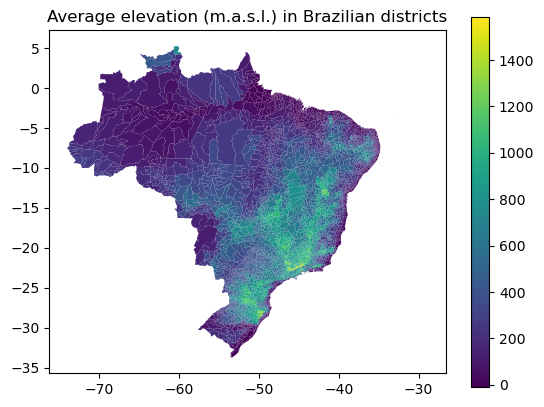

In [174]:
gdf.plot(column='mean_elev', legend=True )
plt.title("Average elevation (m.a.s.l.) in Brazilian districts")

In [81]:
gdf['location'] = gdf['adm2'] + ', ' + gdf['adm1']

## Coastal

In [82]:
coast = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/brazil/coastline.shp')

In [83]:

coast.rename(columns={'ADM1_PT': 'adm1', 'ADM2_PT': 'adm2'}, inplace=True)
coast['adm2'] = coast['adm2'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
coast['adm1'] = coast['adm1'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')



In [84]:
coast['location'] = coast['adm2'] + ', ' + coast['adm1']

In [85]:
gdf['coast'] = [1 if x in coast['location'].unique() else 0 for x in gdf['location']]

<Axes: >

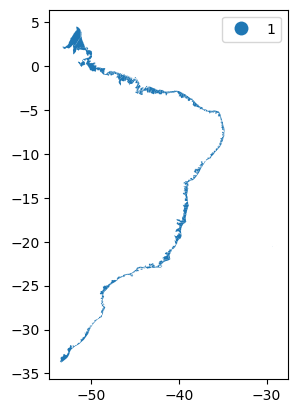

In [86]:
gdf[gdf['coast'] == 1].plot(column='coast', categorical= True, legend=True)

## Human Development Index

In [87]:
import pandas as pd

In [88]:
hdi = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/demographic/brazil/GDL-Subnational-HDI-data.csv')

In [89]:
hdi.rename(columns={'2021':'HDI', 'Region': 'adm1'}, inplace=True)

In [90]:
gdf = gdf.merge(hdi[['adm1', 'HDI']], on='adm1')

In [91]:
len(gdf['adm1'].unique())

27

Text(0.5, 1.0, 'Provincial HDI Brazil')

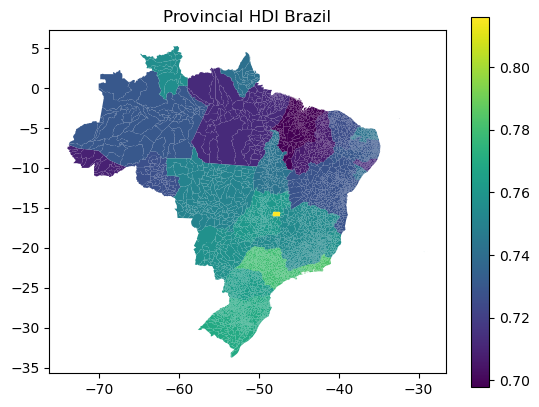

In [92]:
gdf.plot(column='HDI', legend=True)
plt.title('Provincial HDI Brazil')

## Population density (NEW)

In [93]:
with rasterio.open(values) as src:
    print(src.crs)

EPSG:4326


In [ ]:
#using WorldPop Global2 Populatoin Data Set
values = "/Users/shivyucel/Documents/projects/DPhil/Code_Data/paper2_repo/__clean/Global2/brazil/pop/bra_pop_2022_CN_1km_R2025A_UA_v1.tif"


stats = gpd.GeoDataFrame(zonal_stats(gdf, values, stats=["sum"]))
gdf = gdf.join(stats)


# choose correct projection for country
gdf = gdf.to_crs("EPSG:5880")  # SIRGAS 2000 / Brazil Polyconic


#Manually calculate area
gdf['area'] = gdf.geometry.area / 1e6

#manually calculate population density
gdf['popdens'] = gdf['sum'] / gdf['area']

gdf.rename(columns={'ADM0_EN':'adm0'}, inplace=True)

gdf = gdf[['adm0', 'adm1', 'adm2', 'geometry', 'mean_elev', 'location', 'coast', 'HDI', 'popdens']]

#set projection back to 4326 to align with tiff
gdf.to_crs(4326, inplace=True)

## Age (NEW)

/Users/shivyucel/opt/anaconda3/envs/geo2/lib/python3.11/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [126]:
import glob

In [ ]:
# use Global2 age data, summming over all total ages over 60 (deleting all other files in the folder)

gdf['over60_pop'] = 0
for file in glob.glob('/Users/shivyucel/Documents/projects/DPhil/Code_Data/paper2_repo/__clean/Global2/brazil/age/bra_agesex_structures_2022_CN_1km_R2025A_UA_v1/*'):
    
    values = file
    
    pop_total = gpd.GeoDataFrame(zonal_stats(gdf, values, stats=["sum"]))
    gdf['over60_pop'] += pop_total['sum']



#get total population in each adm2 region

for file in glob.glob('/Users/shivyucel/Documents/projects/DPhil/Code_Data/paper2_repo/__clean/Global2/brazil/pop/*'):
    
    values = file
    
    pop_sum = gpd.GeoDataFrame(zonal_stats(gdf, values, stats=["sum"]))
    gdf['pop_total'] = pop_sum['sum']


gdf['over60_propor'] = gdf['over60_pop'] / gdf['pop_total']

/Users/shivyucel/opt/anaconda3/envs/geo2/lib/python3.11/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Text(0.5, 1.0, 'Age 60+ population proportion')

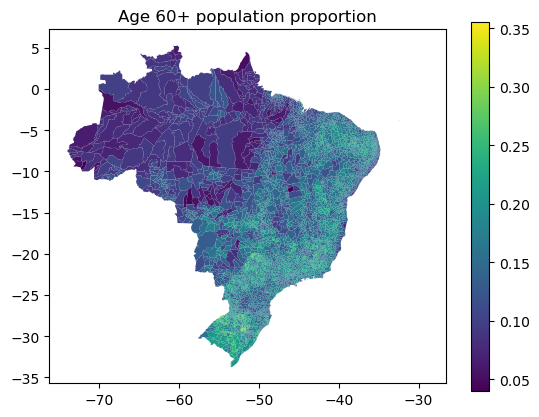

In [130]:
gdf.plot(column='over60_propor', legend=True)
plt.title("Age 60+ population proportion")

In [133]:
HDI_subset = gdf.drop_duplicates('HDI')

In [134]:
deciles = pd.qcut(HDI_subset['HDI'], 10, labels= range(1,11)).astype(int)

In [135]:
HDI_subset['HDI_dec'] = deciles

/Users/shivyucel/opt/anaconda3/envs/geo2/lib/python3.11/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [136]:
gdf = gdf.merge(HDI_subset[['HDI', 'HDI_dec']], on='HDI')

In [137]:
gdf.dropna(subset='over60_pop', inplace=True)

In [138]:
gdf['popdens_dec'] = pd.qcut(gdf['popdens'], 10, labels= range(1,11)).astype(int)
gdf['over60_dec'] = pd.qcut(gdf['over60_propor'], 10, labels= range(1,11)).astype(int)


In [140]:
gdf.to_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/brazil/merged_Global2.shp')

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_41287/1927129610.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/brazil/merged_Global2.shp')
/Users/shivyucel/opt/anaconda3/envs/geo2/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'popdens_dec' to 'popdens_de'
  ogr_write(
/Users/shivyucel/opt/anaconda3/envs/geo2/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'over60_propor' to 'over60_pro'
  ogr_write(


In [ ]:
gdf_old = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/brazil/merged_Global2.shp')

In [160]:
np.corrcoef(gdf['popdens_dec'], gdf_old['popdens_de'])

array([[1.        , 0.98486138],
       [0.98486138, 1.        ]])

In [161]:
np.corrcoef(gdf['over60_dec'], gdf_old['over60_dec'])


array([[1.        , 0.83403568],
       [0.83403568, 1.        ]])